In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno # pip3 install missingno
import seaborn as sns 
sns.set_style("whitegrid")
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

## 1. Load Data

In [2]:
df=pd.read_csv("sothebys.csv", index_col=0)

In [3]:
#convert datatime columns
df.start_date =pd.to_datetime(df.start_date)
df.end_date =pd.to_datetime(df.end_date)

In [4]:
# Check Auction length
cnt=np.where(df["end_date"]!=df["start_date"],1,0).sum()
#cnt=0
df.drop("end_date",axis=1,inplace=True)

Therefore, we'll use $start\_date$ as the time that the auction occured going forward. 

In [5]:
#clean up birth_year
df.birth_year=pd.to_numeric(df.birth_year,errors='coerce').fillna(0).astype(np.int64)

## 2. Add Features

In [6]:
# Add year, month and season for auction time
df["auc_date"] = pd.DatetimeIndex(df.start_date).normalize()
df['auc_year'] = pd.DatetimeIndex(df['start_date']).year
df['auc_month'] = pd.DatetimeIndex(df['start_date']).month
df['auc_season'] = df["start_date"].apply(lambda dt: (dt.month%12 + 3)//3)

In [7]:
# Add a boolean column to indicate if the lot is named "untitled"
words='|'.join(["INTITULADO","UNTITLED","OHNE TITEL","SANS TITRE","SENZA TITOLO"])
df["is_untitled"]=np.where(df["lot_title"].str.contains(words), 1, 0)
df.is_untitled.value_counts()

0    16574
1     6137
Name: is_untitled, dtype: int64

In [8]:
# Normalize "nth_in_auction" column by "auction_id" into 10 tiles
df["auc_order"]= df.groupby("auction_id")["nth_in_auction"].transform(
                     lambda x: pd.qcut(x, 10, labels=range(1,11))) 

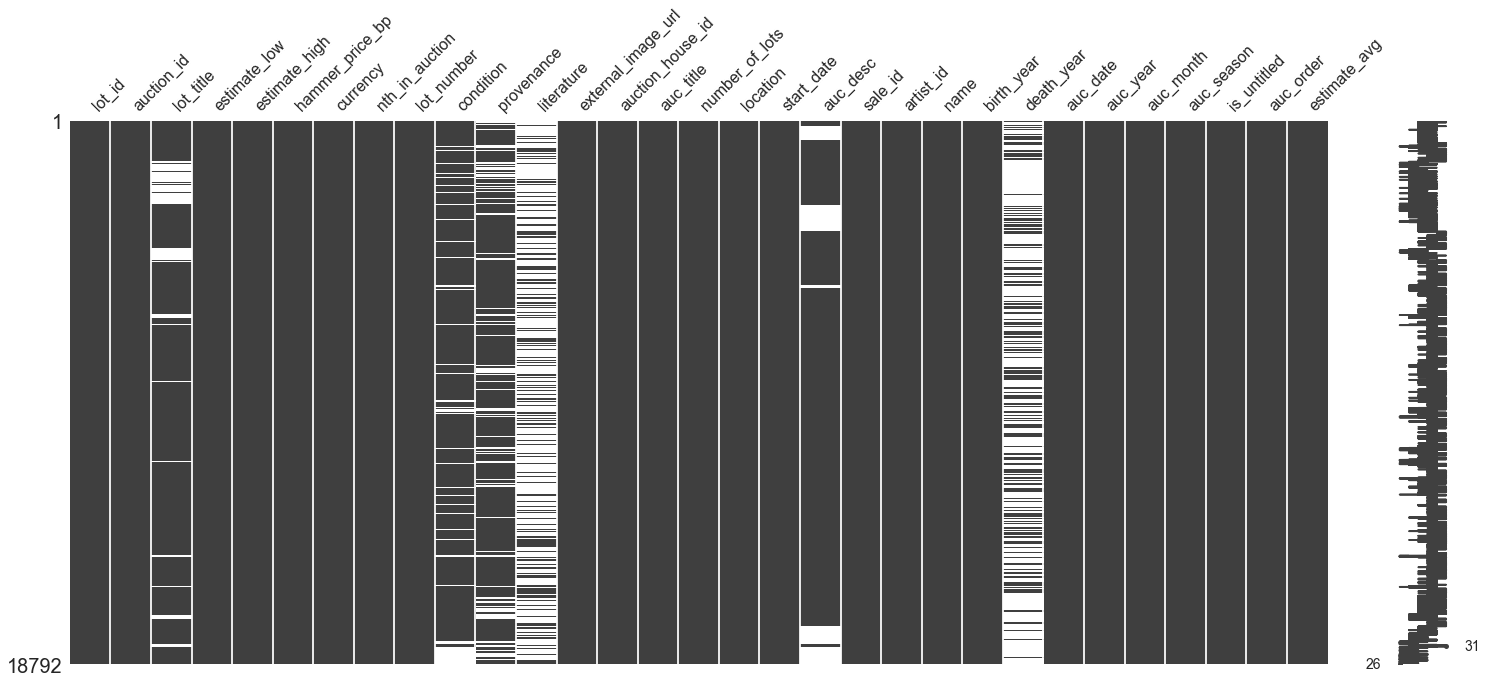

In [9]:
# Add avg_estimate
df = df.dropna(subset=['estimate_low', 'estimate_high', 'hammer_price_bp'])

df["estimate_avg"]=(df["estimate_low"] + df["estimate_high"])/2

msno.matrix(df)

## 3. Convert Currency

In [12]:
# pip install --user currencyconverter
from currency_converter import CurrencyConverter
from datetime import datetime
c = CurrencyConverter(fallback_on_wrong_date=True, fallback_on_missing_rate=True)

hammer_price = df[['hammer_price_bp', 'currency', 'start_date']].copy()
est_low = df[['estimate_low', 'currency', 'start_date']].copy()
est_high = df[['estimate_high', 'currency', 'start_date']].copy()
est_avg = df[['estimate_avg', 'currency', 'start_date']].copy()

hammer_price.start_date = hammer_price.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_low.start_date = est_low.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_high.start_date = est_high.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)
est_avg.start_date = est_avg.start_date.apply(lambda x: x.strftime('%Y-%m-%d') if not pd.isnull(x) else x)

df['hammer_price_bp_usd'] = np.apply_along_axis(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2), 1, hammer_price)
df['estimate_low_usd'] = np.apply_along_axis(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2), 1, est_low)    
df['estimate_high_usd'] = np.apply_along_axis(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2), 1, est_high)
df['estimate_avg_usd'] = np.apply_along_axis(lambda x: np.round(c.convert(x[0], x[1], 'USD', date=pd.to_datetime(x[2])), 2), 1, est_avg)

In [15]:
df.head()

,lot_id,auction_id,lot_title,estimate_low,estimate_high,hammer_price_bp,currency,nth_in_auction,lot_number,condition,provenance,literature,external_image_url,auction_house_id,auc_title,number_of_lots,location,start_date,auc_desc,sale_id,artist_id,name,birth_year,death_year,auc_date,auc_year,auc_month,auc_season,is_untitled,auc_order,estimate_avg,hammer_price_bp_usd,estimate_low_usd,estimate_high_usd,estimate_avg_usd
174,22713,216,YELLOW IRIS DIPTYCH,10000.0,15000.0,8750.0,USD,283,336,Left canvas: In good condition. Slight ripple...,Acquired directly from the artist by the prese...,NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art,285,NEW YORK,2010-03-09 15:00:00,OVERVIEW\n\nSotheby's March 9th Contemporary A...,N08617,1449,Lowell Nesbitt,1933,1993,2010-03-09,2010,3,2,0,10,12500.0,8750.0,10000.0,15000.0,12500.0
175,22712,216,UNTITLED (NUDE WITH HAT AND TWO PARROTS): A PAIR,5000.0,7000.0,9375.0,USD,282,335,i) In good condition. Sheet slightly irregula...,NaN,NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art,285,NEW YORK,2010-03-09 15:00:00,OVERVIEW\n\nSotheby's March 9th Contemporary A...,N08617,885,Walasse Ting,1929,NaN,2010-03-09,2010,3,2,1,10,6000.0,9375.0,5000.0,7000.0,6000.0
176,22711,216,UNTITLED,12000.0,18000.0,18750.0,USD,281,334,In good condition. In large 19th century fram...,NaN,NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art,285,NEW YORK,2010-03-09 15:00:00,OVERVIEW\n\nSotheby's March 9th Contemporary A...,N08617,8546,Shen Hanwu,1950,NaN,2010-03-09,2010,3,2,1,10,15000.0,18750.0,12000.0,18000.0,15000.0
177,22710,216,UNTITLED,10000.0,12000.0,17500.0,USD,280,332,Work is stamped with estate stamp and numbered...,NaN,NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art,285,NEW YORK,2010-03-09 15:00:00,OVERVIEW\n\nSotheby's March 9th Contemporary A...,N08617,8545,Leonard Nelson,1912,1993,2010-03-09,2010,3,2,1,10,11000.0,17500.0,10000.0,12000.0,11000.0
178,22704,216,PHENOMENA RIM OF AUGUST,12000.0,16000.0,31250.0,USD,279,331,In good condition aside from slight surface du...,"Gimpel and Weitzenhoffer, Ltd., New York",NaN,http://www.sothebys.com/content/dam/default/un...,1,Contemporary Art,285,NEW YORK,2010-03-09 15:00:00,OVERVIEW\n\nSotheby's March 9th Contemporary A...,N08617,5793,Paul Jenkins,1923,NaN,2010-03-09,2010,3,2,0,10,14000.0,31250.0,12000.0,16000.0,14000.0


## 4. Export to CSV

In [16]:
df.to_csv("final_sothebys.csv")

In [17]:
df.shape

(18792, 35)